# Scenarios and Levels specified in the national plan

| **Scenario(s)** | **Trigger Type**               | **Alert Level** | **Description**                                                                 |
|-----------------|-------------------------------|------------------|---------------------------------------------------------------------------------|
| 1 & 3           | Clinical & Epidemiological    | Level 0         | Safe zone + slight increase in diarrhea cases                                  |
| 1 & 3           | Clinical & Epidemiological    | Level 1         | Alert zone + <30% adult cases + rumors of community increase                   |
| 1 & 3           | Clinical & Epidemiological    | Level 2         | Epidemic zone + ≥30% adult cases + community cases or deaths                   |
| 1 & 3           | Clinical & Epidemiological    | Level 3         | Positive RDT + Positive culture + ≥10% hospitalization rate                    |
| 2               | Climate Event                 | Level 0         | Weather alert for above-average rainfall or flood risk                         |
| 2               | Climate Event                 | Level 1         | Disaster alert + risk to water/sanitation in cholera hotspots                  |
| 2               | Climate Event                 | Level 2         | Disaster occurred + ≥30% adult cases or community deaths                       |
| 2               | Humanitarian Crisis           | Level 1         | Armed attacks in cholera hotspot areas                                         |
| 2               | Humanitarian Crisis           | Level 2         | Armed attacks + displacement + ≥30% adult cases or community deaths            |


This notebook looks at the increase in cases by district and how often the 30% increase is recorded.

In [74]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
# Data and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
import re

# Azure Blob Storage
from azure.storage.blob import ContainerClient, BlobClient
import io

# Display settings
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.0f}".format
sns.set(style="whitegrid")

In [76]:
postos_path = (
    Path(os.getenv("AA_DATA_DIR"))
    / "private"
    / "raw"
    / "moz"
    / "cholera"
    / "DISTRIBUIÇÃO DAS ZONAS QUENTES E DE ALTO RISCO DE CÓLERA NO PAÍS.xlsx"
)

Consolidating the worksheets in the file into one table.


In [77]:
postos_risk_all = pd.read_excel(postos_path, sheet_name=None, header=None)
postos_dfs = list(postos_risk_all.values())

# Read first sheet again with headers to get column names
postos_risk = pd.read_excel(postos_path, sheet_name="Table042 (Page 38)")
columns = postos_risk.columns

# Process remaining sheets: skip first row, assign headers
for df in postos_dfs[1:]:
    df = df.iloc[1:]
    df.columns = columns
    postos_risk = pd.concat([postos_risk, df], ignore_index=True)

# Remove rows with NaN in 'provincia'
postos_risk = postos_risk[postos_risk["Província"].notna()]
# Remove \n from all string values
for col in postos_risk.select_dtypes(include="object"):
    postos_risk[col] = postos_risk[col].map(
        lambda x: re.sub(r"\s+", " ", x).strip() if isinstance(x, str) else x
    )
# Standardize column names (lowercase, replace spaces and special characters with underscores)
postos_risk.columns = (
    postos_risk.columns.str.lower()
    .str.replace(r"\s+", "_", regex=True)
    .str.replace(r"[^a-z0-9_]", "", regex=True)
)

In [78]:
postos_risk[postos_risk["provncia"] == "Nampula"]["distrito"].unique()

array(['Nampula', 'Meconta', 'Memba', 'Nacala-Porto', 'Monapo', 'Eráti',
       'Nacaroa', 'Mogovolas', 'Moma', 'Larde', 'Ribaué', 'Malema',
       'Angoche', 'Mecuburi', 'Nacala-a-Ve-lha', 'Murrupula', 'Muecate',
       'Lalaua', 'Ilha de Mo-çambique'], dtype=object)

In [79]:
postos_risk.to_csv(
    Path(os.getenv("AA_DATA_DIR"))
    / "private"
    / "processed"
    / "moz"
    / "cholera"
    / "postos_risk_levels.csv",
    index=False,
    encoding="utf-8",
    quotechar='"',
    quoting=1,
)

In [80]:
postos_risk_sel = postos_risk.groupby("distrito").filter(
    lambda df: len(df) == 1
)
postos_risk_sel[postos_risk_sel["provncia"] == "Nampula"]

,cod,provncia,distrito,carga_clera,carga_diarreia,unidade_administrativa_posto_administrativo_bairro,classificao_de_risco_de_clera,populao_exposta_2023,incidncia_mdia_anual_da_clera,incidncia_mdia_anual_da_diarreia
115,MACC2_114,Nampula,Moma,4,3,Moma-Sede,Zona Quente,248670,9.45,582.60
139,MACC2_137,Nampula,Larde,3,5,Sede,Zona Quente,54622,35.27,"3,455"
140,MACC2_138,Nampula,Ribaué,3,5,Sede,Zona Quente,107901,9.18,"1,017"
156,MACC2_154,Nampula,Nacala-a-Ve-lha,2,4,Sede,Zona Quente,97982,18.80,"1,024"
182,MACC2_180,Nampula,Muecate,0,7,Imala,Zona de Alto Risco,67680,-,"2,695"
247,MACC2_244,Nampula,Lalaua,1,4,Sede,Zona de Alto Risco,80688,13.04,"2,149"


Starting with the districts with one posto and checking for a 30% increase.
Weekly increase check

In [81]:
district_df = pd.read_csv(
    Path(os.getenv("AA_DATA_DIR"))
    / "private"
    / "processed"
    / "moz"
    / "cholera"
    / "cholera_data_cleaned.csv"
)
# only keep those with week values
district_df = district_df[district_df["week"].notna()]

In [82]:
matching_distritos = postos_risk[
    postos_risk["distrito"].isin(district_df["district"])
]

In [83]:
# weekly increase in cases per district
district_df["weekly_pct_increase"] = (
    district_df
    # group by district and calculate percentage change
    .groupby("district")["cases"].pct_change(fill_method=None)
    * 100
)
district_df

,province,district,year,week,cases,weekly_pct_increase
0,Nampula,Angoche,2018,1,62,NaN
1,Nampula,Angoche,2018,2,74,19
2,Nampula,Angoche,2018,3,69,-7
3,Nampula,Angoche,2018,4,67,-3
4,Nampula,Angoche,2018,5,135,101
...,...,...,...,...,...,...
14136,Zambezia,Quelim,2024,48,371,-6
14137,Zambezia,Quelim,2024,49,311,-16
14138,Zambezia,Quelim,2024,50,373,20
14139,Zambezia,Quelim,2024,51,317,-15


In [84]:
# merging the two dataframes on 'distrito' column
district_df_risk = district_df.merge(
    postos_risk[["distrito", "classificao_de_risco_de_clera"]],
    left_on="district",
    right_on="distrito",
    how="left",
)

In [85]:
cond_alto = (
    (district_df_risk["classificao_de_risco_de_clera"] == "Zona de Alto Risco")
    & (district_df_risk["weekly_pct_increase"] > 0)
    & (district_df_risk["weekly_pct_increase"] < 30)
)

cond_quente = (
    district_df_risk["classificao_de_risco_de_clera"] == "Zona Quente"
) & (district_df_risk["weekly_pct_increase"] >= 30)
district_df_risk["meets_criteria"] = np.where(
    cond_alto | cond_quente, True, False
)
district_df_risk["in_season"] = pd.to_datetime(
    district_df_risk["year"].astype(int).astype(str)
    + district_df_risk["week"].fillna(0).astype(int).astype(str).str.zfill(2)
    + "1",
    format="%G%V%u",
).dt.month.isin([10, 11, 12, 1, 2, 3, 4])
triggered = district_df_risk[
    district_df_risk["meets_criteria"] & district_df_risk["in_season"]
]
triggered

,province,district,year,week,cases,weekly_pct_increase,distrito,classificao_de_risco_de_clera,meets_criteria,in_season
5,Nampula,Angoche,2018,2,74,19,Angoche,Zona de Alto Risco,True,True
6,Nampula,Angoche,2018,2,74,19,Angoche,Zona de Alto Risco,True,True
7,Nampula,Angoche,2018,2,74,19,Angoche,Zona de Alto Risco,True,True
16,Nampula,Angoche,2018,5,135,101,Angoche,Zona Quente,True,True
24,Nampula,Angoche,2018,7,76,33,Angoche,Zona Quente,True,True
...,...,...,...,...,...,...,...,...,...,...
25855,Zambezia,Pebane,2024,12,113,30,Pebane,Zona de Alto Risco,True,True
25860,Zambezia,Pebane,2024,17,117,4,Pebane,Zona de Alto Risco,True,True
25861,Zambezia,Pebane,2024,18,128,9,Pebane,Zona de Alto Risco,True,True
25889,Zambezia,Pebane,2024,46,94,21,Pebane,Zona de Alto Risco,True,True


In [86]:
# Extract unique weeks and years for each district
district_trigger_weeks_years_count = (
    triggered.groupby(
        ["province", "district", "year", "classificao_de_risco_de_clera"]
    )["week"]
    .count()
    .reset_index(name="week_count")
)
district_trigger_weeks_years_count

,province,district,year,classificao_de_risco_de_clera,week_count
0,Nampula,Angoche,2018,Zona Quente,9
1,Nampula,Angoche,2018,Zona de Alto Risco,9
2,Nampula,Angoche,2019,Zona Quente,12
3,Nampula,Angoche,2019,Zona de Alto Risco,9
4,Nampula,Angoche,2020,Zona Quente,11
...,...,...,...,...,...
199,Zambezia,Pebane,2020,Zona de Alto Risco,8
200,Zambezia,Pebane,2021,Zona de Alto Risco,12
201,Zambezia,Pebane,2022,Zona de Alto Risco,14
202,Zambezia,Pebane,2023,Zona de Alto Risco,10


This threshold is reached annually. While there are other conditions in the trigger, it is still concerning.

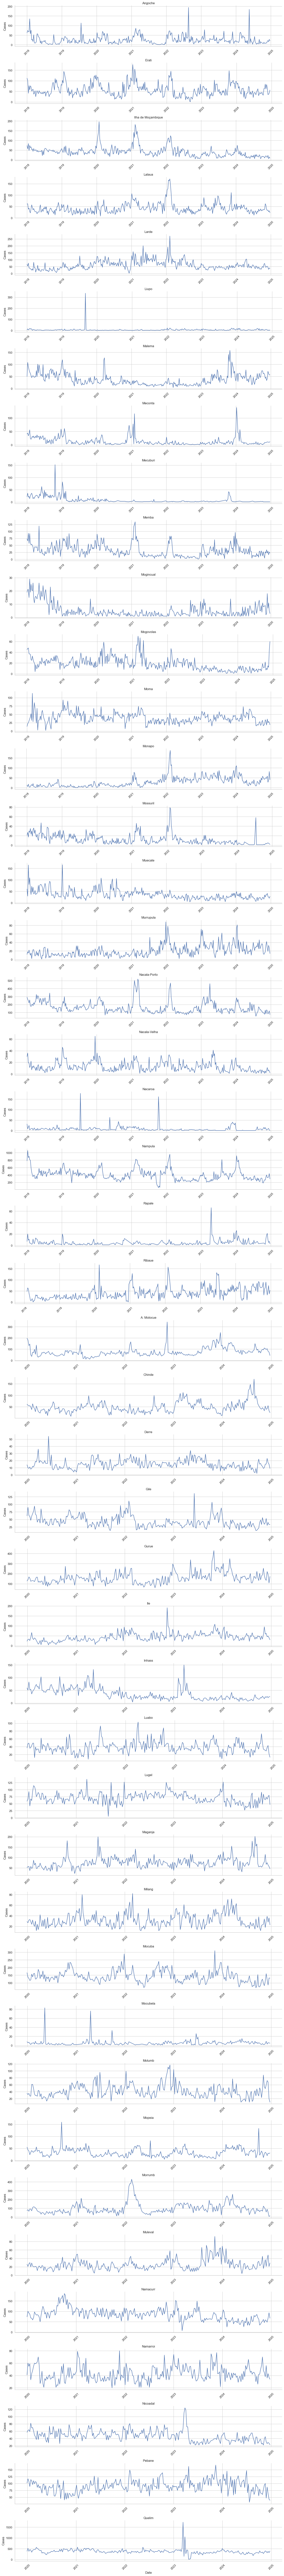

In [87]:
# general plots
# Create a "date" column from year and week
district_df["date"] = pd.to_datetime(
    district_df["year"].astype(str)
    + district_df["week"].astype(int).astype(str).str.zfill(2)
    + "1",
    format="%G%V%u",
)

# Plot with one column
g = sns.FacetGrid(
    district_df,
    col="district",
    col_wrap=1,
    sharex=False,
    sharey=False,
    height=3,
    aspect=5,
)
g.map_dataframe(sns.lineplot, x="date", y="cases")

g.set_titles("{col_name}")
g.set_axis_labels("Date", "Cases")
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
plt.tight_layout()
plt.show()

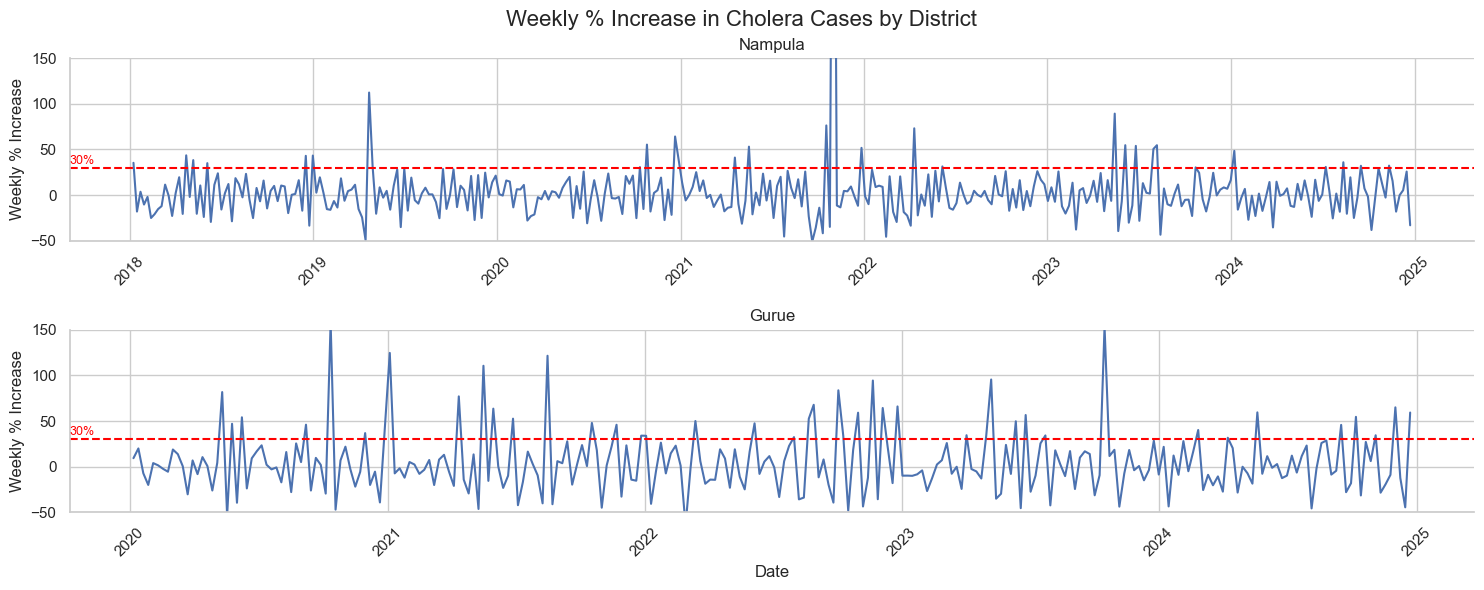

In [88]:
# Plot with one column
g = sns.FacetGrid(
    district_df[district_df["district"].isin(["Nampula", "Gurue"])],
    col="district",
    col_wrap=1,
    sharex=False,
    sharey=False,
    height=3,
    aspect=5,
)
g.map_dataframe(sns.lineplot, x="date", y="weekly_pct_increase")
# Add horizontal red line at y=30
for ax in g.axes.flat:
    ax.axhline(30, color="red", linestyle="--", linewidth=1.5)
    ax.text(
        ax.get_xlim()[0],
        30 + 1,
        "30%",  # Adjust position as needed
        color="red",
        fontsize=9,
        va="bottom",
    )
    for label in ax.get_xticklabels():
        label.set_rotation(45)
g.set_titles("{col_name}")
g.set_axis_labels("Date", "Weekly % Increase")
g.set(ylim=(-50, 150))
g.fig.suptitle("Weekly % Increase in Cholera Cases by District", fontsize=16)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [89]:
district_df_risk

,province,district,year,week,cases,weekly_pct_increase,distrito,classificao_de_risco_de_clera,meets_criteria,in_season
0,Nampula,Angoche,2018,1,62,NaN,Angoche,Zona Quente,False,True
1,Nampula,Angoche,2018,1,62,NaN,Angoche,Zona de Alto Risco,False,True
2,Nampula,Angoche,2018,1,62,NaN,Angoche,Zona de Alto Risco,False,True
3,Nampula,Angoche,2018,1,62,NaN,Angoche,Zona de Alto Risco,False,True
4,Nampula,Angoche,2018,2,74,19,Angoche,Zona Quente,False,True
...,...,...,...,...,...,...,...,...,...,...
26151,Zambezia,Quelim,2024,48,371,-6,NaN,NaN,False,True
26152,Zambezia,Quelim,2024,49,311,-16,NaN,NaN,False,True
26153,Zambezia,Quelim,2024,50,373,20,NaN,NaN,False,True
26154,Zambezia,Quelim,2024,51,317,-15,NaN,NaN,False,True


In [90]:
# summary showing how many districts have weekly increase >= 30% every year
summary_counts = (
    district_df_risk[district_df_risk["weekly_pct_increase"] >= 30]
    .groupby(["province", "year"])["district"]
    .nunique()
    .unstack(fill_value=0)
)
total_districts = (
    district_df_risk.groupby(["province", "year"])["district"]
    .nunique()
    .unstack(fill_value=0)
)
summary_counts / total_districts
summary_counts

year,2018,2019,2020,2021,2022,2023,2024
province,,,,,,,
Nampula,23,23,23,23,23,23,23
Zambezia,0,0,22,22,22,22,22


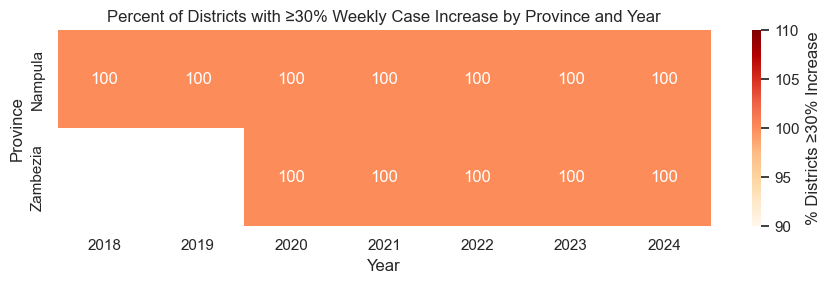

In [91]:
# Compute percentages
percent_affected = (summary_counts / total_districts * 100).round(1)

# Plot
plt.figure(figsize=(9, 3))
sns.heatmap(
    percent_affected,
    annot=True,
    fmt=".0f",
    cmap="OrRd",
    cbar_kws={"label": "% Districts ≥30% Increase"},
)
plt.title(
    "Percent of Districts with ≥30% Weekly Case Increase by Province and Year"
)
plt.xlabel("Year")
plt.ylabel("Province")
plt.grid(False)
plt.tight_layout()
plt.show()

Testing out the DRC trigger using this data.
 - 99th percentile OR 4x increase: for 3 consecutive weeks

Using the 99th percentile per province. Leaving out a minimum number of districts here.

In [92]:
# Calculate percentiles per province
percentiles = (
    district_df.groupby("province")["cases"].quantile([0.99]).unstack()
)

# Merge percentiles back into the main df
district_df_with_percentiles = district_df.merge(
    percentiles.rename(columns={0.99: "p99"}),
    left_on="province",
    right_index=True,
    how="left",
)
district_df_with_percentiles[
    district_df_with_percentiles["weekly_pct_increase"] >= 400
]

,province,district,year,week,cases,weekly_pct_increase,date,p99
39,Nampula,Angoche,2018,40,10,400,2018-10-01,496
40,Nampula,Angoche,2018,41,53,430,2018-10-08,496
138,Nampula,Angoche,2020,35,31,"3,000",2020-08-24,496
206,Nampula,Angoche,2021,51,11,"1,000",2021-12-20,496
208,Nampula,Angoche,2022,1,48,700,2022-01-03,496
...,...,...,...,...,...,...,...,...
12417,Zambezia,Morrumb,2021,45,61,408,2021-11-08,428
12529,Zambezia,Morrumb,2024,1,117,409,2024-01-01,428
13007,Zambezia,Namacurr,2023,11,38,443,2023-03-13,428
14049,Zambezia,Quelim,2023,13,"1,050",634,2023-03-27,428


In [167]:
# Check if cases cross the thresholds
district_df_with_percentiles["above_99th"] = (
    district_df_with_percentiles["cases"] > district_df_with_percentiles["p99"]
)
district_df_with_percentiles["above_4x"] = (
    district_df_with_percentiles["weekly_pct_increase"] >= 400
)
district_df_with_percentiles["threshold_crossed"] = (
    district_df_with_percentiles["above_99th"]
    | district_df_with_percentiles["above_4x"]
)
district_df_with_percentiles = district_df_with_percentiles.sort_values(
    ["district", "year", "week"]
)
# Create the new column: True only if this week and the previous two weeks are above the 99th percentile
district_df_with_percentiles["three_consec_crossing"] = (
    district_df_with_percentiles["threshold_crossed"]
    & district_df_with_percentiles.groupby("district")[
        "threshold_crossed"
    ].shift(1)
    & district_df_with_percentiles.groupby("district")[
        "threshold_crossed"
    ].shift(2)
    & (
        (
            (district_df_with_percentiles["province"] == "Zambezia")
            & (district_df_with_percentiles["cases"] >= 500)
        )
        | (
            (district_df_with_percentiles["province"] == "Nampula")
            & (district_df_with_percentiles["cases"] >= 800)
        )
    )
)
district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
][["province", "district"]].drop_duplicates()

,province,district
7331,Nampula,Nampula
13891,Zambezia,Quelim


In [168]:
# which of the weeks and years are above the 99th percentile? count the number of districts
district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
][["year", "week"]].drop_duplicates().sort_values(["year", "week"])
# the number of districts by year and by province when the threshold was crossed
all_years = district_df_with_percentiles["year"].unique()
district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
].groupby(["province", "year"])["district"].nunique().unstack(
    fill_value=0
).reindex(
    columns=sorted(all_years), fill_value=0
)

year,2018,2019,2020,2021,2022,2023,2024
province,,,,,,,
Nampula,1,0,0,1,1,0,1
Zambezia,0,0,1,1,0,0,0


In [169]:
# Filter if you want only the crossings
crossed_99th = district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
]

district_trigger_99th = (
    crossed_99th.groupby(["province", "district", "year"])["week"]
    .count()
    .reset_index(name="week_count")
)
district_trigger_99th

,province,district,year,week_count
0,Nampula,Nampula,2018,3
1,Nampula,Nampula,2021,3
2,Nampula,Nampula,2022,2
3,Nampula,Nampula,2024,2
4,Zambezia,Quelim,2020,2
5,Zambezia,Quelim,2021,2


In [170]:
# which month activates for each district
crossed_99th["month"] = crossed_99th["date"].dt.month

district_activation_month = (
    crossed_99th.sort_values("date")
    .groupby(["province", "district", "year"])["month"]
    .first()
    .reset_index(name="activation_month")
)
district_activation_month.pivot_table(
    index="province",
    columns="year",
    values="activation_month",
    aggfunc="first",  # or "min" if multiple activations per year
).sort_index().fillna("")

C:\Users\pauni\AppData\Local\Temp\ipykernel_10764\2234602487.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crossed_99th["month"] = crossed_99th["date"].dt.month


year,2018,2020,2021,2022,2024
province,,,,,
Nampula,1,,2,1,1
Zambezia,,3,3,,


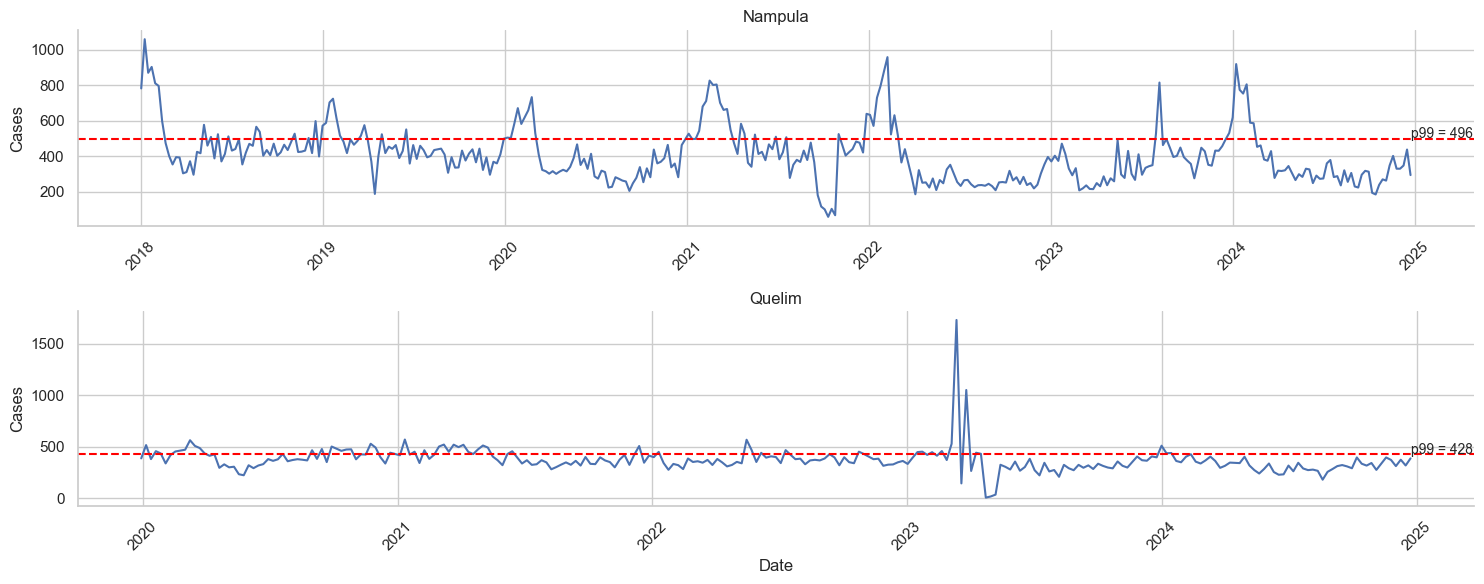

In [171]:
# plot 99th percentile crossings
g = sns.FacetGrid(
    district_df_with_percentiles[
        district_df_with_percentiles["district"].isin(["Nampula", "Quelim"])
    ],
    col="district",
    col_wrap=1,
    sharex=False,
    sharey=False,
    height=3,
    aspect=5,
)

g.map_dataframe(sns.lineplot, x="date", y="cases")

g.map_dataframe(
    lambda data, color, **kws: (
        plt.axhline(y=data["p99"].iloc[0], color="red", linestyle="--"),
        plt.text(
            data["date"].max(),
            data["p99"].iloc[0] + 5,
            f"p99 = {int(data['p99'].iloc[0])}",
            fontsize=10,
        ),
    )
)

g.set_titles("{col_name}")
g.set_axis_labels("Date", "Cases")
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

In [172]:
district_df_with_percentiles.columns

Index(['province', 'district', 'year', 'week', 'cases', 'weekly_pct_increase',
       'date', 'p99', 'above_99th', 'above_4x', 'threshold_crossed',
       'three_consec_crossing'],
      dtype='object')

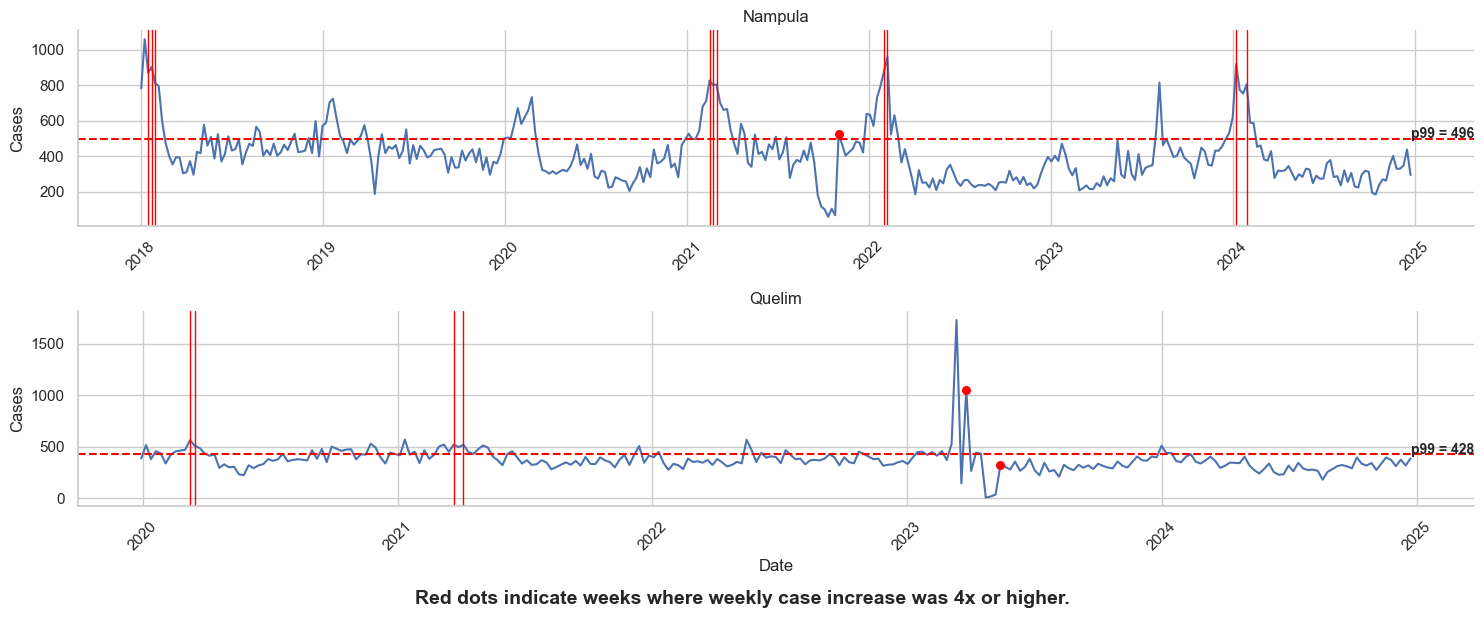

In [173]:
g = sns.FacetGrid(
    district_df_with_percentiles[
        district_df_with_percentiles["district"].isin(["Nampula", "Quelim"])
    ],
    col="district",
    col_wrap=1,
    sharex=False,
    sharey=False,
    height=3,
    aspect=5,
)

# Line plot of cases
g.map_dataframe(sns.lineplot, x="date", y="cases")

# Add 99th percentile line
g.map_dataframe(
    lambda data, color, **kws: (
        plt.axhline(y=data["p99"].iloc[0], color="red", linestyle="--"),
        plt.text(
            data["date"].max(),
            data["p99"].iloc[0] + 5,
            f"p99 = {int(data['p99'].iloc[0])}",
            fontsize=10,
            fontweight="bold",
        ),
    )
)

# Add red dots where weekly_pct_increase >= 400
g.map_dataframe(
    lambda data, **kws: plt.scatter(
        data.loc[data["weekly_pct_increase"] >= 400, "date"],
        data.loc[data["weekly_pct_increase"] >= 400, "cases"],
        color="red",
        s=30,
        zorder=5,
    )
)


def add_vertical_lines(data, **kwargs):
    for date in data.loc[data["three_consec_crossing"], "date"]:
        plt.axvline(x=date, color="red", linestyle="-", linewidth=1)


g.map_dataframe(add_vertical_lines)

g.set_titles("{col_name}")
g.set_axis_labels("Date", "Cases")
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.figtext(
    0.5,
    -0.02,
    "Red dots indicate weeks where weekly case increase was 4x or higher.",
    ha="center",
    fontsize=14,
    fontweight="bold",
)
plt.show()

C:\Users\pauni\AppData\Local\Temp\ipykernel_10764\641879416.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["province", "year", "month"])


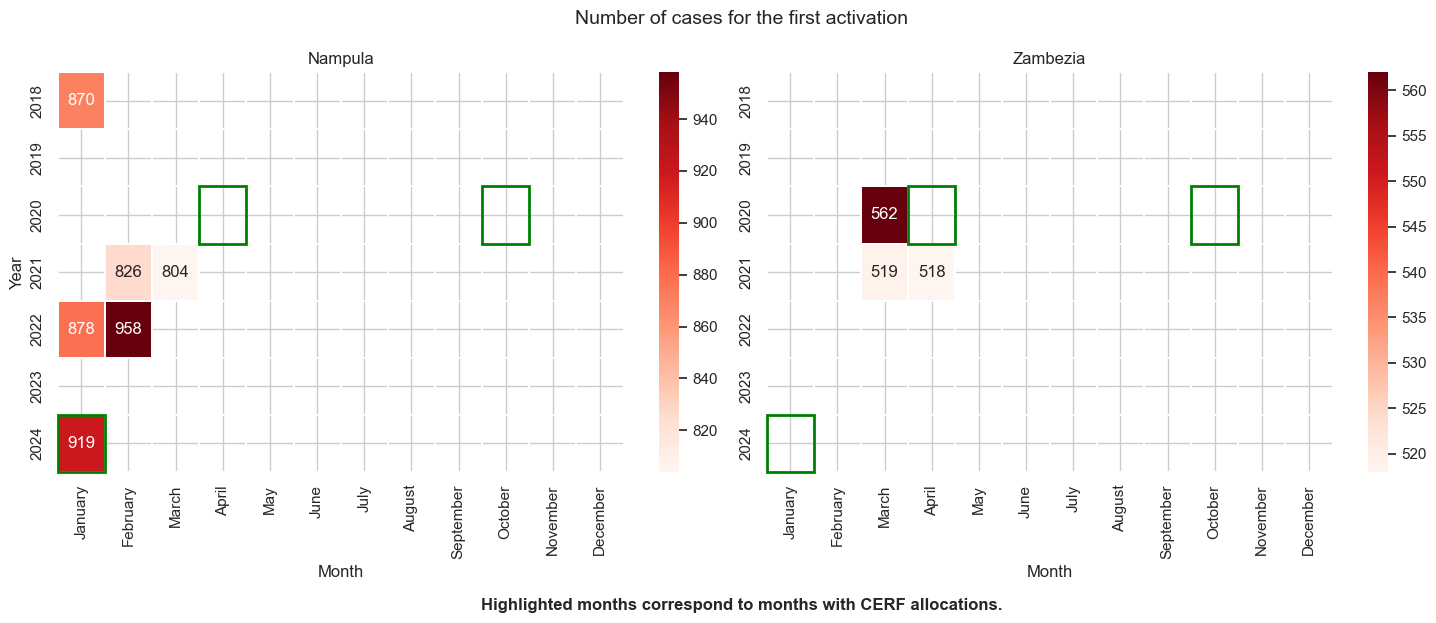

In [174]:
df = district_df_with_percentiles.copy()
df["date"] = pd.to_datetime(df["date"])

df["month"] = df["date"].dt.strftime("%B")

month_order = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]
df["month"] = pd.Categorical(df["month"], categories=month_order, ordered=True)

summary = (
    df[df["three_consec_crossing"]]
    .groupby(["province", "year", "month"])
    .agg(
        num_trigger_weeks=("week", "nunique"),
        cases=("cases", "first"),
        districts=("district", lambda x: ", ".join(sorted(set(x)))),
    )
    .reset_index()
    .rename(columns={"ADM1_PT": "province"})
    .sort_values(["province", "year", "month"])
)

# Full year range
all_years = list(range(df["year"].min(), df["year"].max() + 1))

# Faceted heatmap by province
g = sns.FacetGrid(
    summary,
    col="province",
    col_wrap=2,
    height=6,
    aspect=1.25,
    sharex=False,
    sharey=False,
)


def heatmap_crossing(data, **kwargs):
    table = data.pivot_table(
        index="year",
        columns="month",
        values="cases",
        aggfunc="first",
        observed=False,
    ).reindex(index=all_years, columns=month_order)

    sns.heatmap(
        table,
        cmap="Reds",
        cbar=True,
        annot=True,
        fmt=".0f",
        linewidths=0.3,
        linecolor="white",
        mask=(table == 0),
    )
    ax = plt.gca()

    # Outline targets
    highlight_cells = [
        (2020, "April"),
        (2020, "October"),
        (2024, "January"),
    ]

    # Loop and draw rectangles
    for year, month in highlight_cells:
        try:
            row_idx = table.index.get_loc(year)
            col_idx = table.columns.get_loc(month)
            ax.add_patch(
                plt.Rectangle(
                    (col_idx, row_idx),
                    1,
                    1,
                    fill=False,
                    edgecolor="green",
                    linewidth=2,
                    clip_on=False,
                )
            )
        except KeyError:
            continue


g.map_dataframe(heatmap_crossing)
g.set_titles("{col_name}")
g.set_axis_labels("Month", "Year")
g.fig.suptitle("Number of cases for the first activation", fontsize=14)
plt.figtext(
    0.5,
    -0.02,
    "Highlighted months correspond to months with CERF allocations.",
    ha="center",
    fontsize=12,
    fontweight="bold",
)
plt.tight_layout()
plt.show()